# Trabalho grupo 7

In [1]:
import csv
import stanza
import evaluate
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, create_optimizer, pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D, Bidirectional


# Importing dataset
rt_train = pd.read_csv('./rotten_tomatoes_train.tsv', sep='\t', names=['Stuff', 'Sentiment', 'Text'])
rt_test = pd.read_csv('./rotten_tomatoes_test.tsv', sep='\t', names=['Stuff', 'Sentiment', 'Text'])

rt_train = rt_train.drop(labels='Stuff',axis=1)
rt_test = rt_test.drop(labels='Stuff',axis=1)

In [2]:
rt_test

,Sentiment,Text
0,negative,With a tighter editorial process and firmer di...
1,positive,If ever a concept came handed down from the mo...
2,negative,Whether Jason X is this bad on purpose is neve...
3,positive,Alternates between deadpan comedy and heartbre...
4,neutral,"God is great , the movie 's not ."
...,...,...
1724,neutral,Innocuous enough to make even Jean-Claude Van ...
1725,positive,A sensitive and astute first feature by Anne-S...
1726,positive,"Brilliantly written and well-acted , Yellow As..."
1727,positive,"And it sees those relationships , including th..."


Aglumerar dados de treino por sentimento calculando a quantidade de cada tipo de sentimento, para calcular a percentagem de cada sentimento e depois ilustrar num Pie Chart

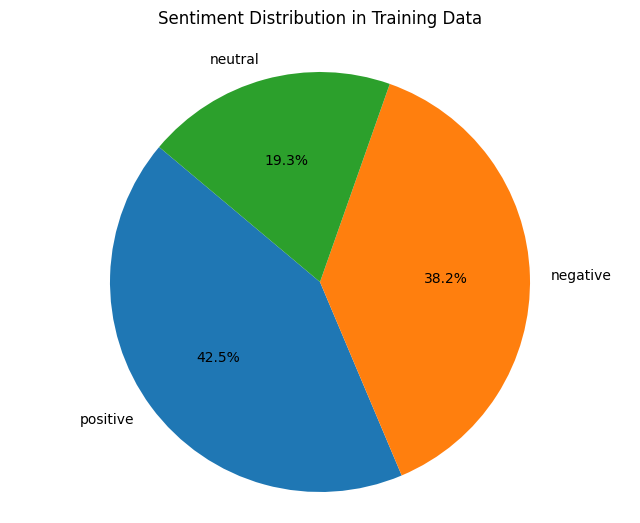

In [3]:
sentiment_counts_train = rt_train['Sentiment'].value_counts()
sentiment_percentages_train = (sentiment_counts_train / sentiment_counts_train.sum()) * 100

plt.figure(figsize=(8, 6))
plt.pie(sentiment_percentages_train, labels=sentiment_percentages_train.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Training Data', pad=20)
plt.axis('equal')
plt.show()

Aglumerar dados de teste por sentimento calculando a quantidade de cada tipo de sentimento, para calcular a percentagem de cada sentimento e depois ilustrar num Pie Chart

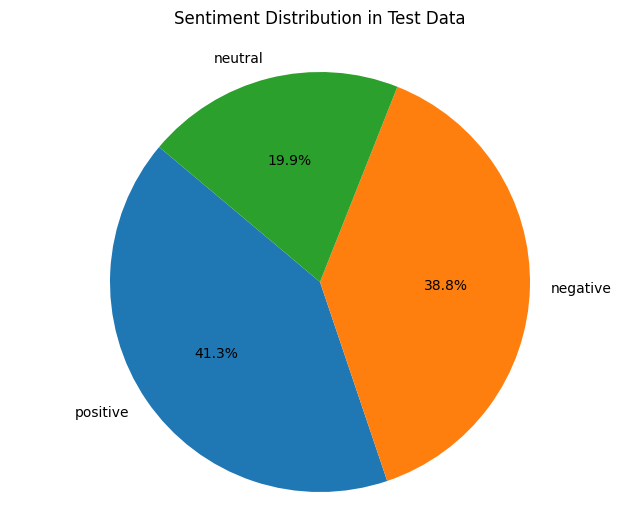

In [4]:
sentiment_counts_train = rt_test['Sentiment'].value_counts()
sentiment_percentages_train = (sentiment_counts_train / sentiment_counts_train.sum()) * 100

plt.figure(figsize=(8, 6))
plt.pie(sentiment_percentages_train, labels=sentiment_percentages_train.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Test Data', pad=20)
plt.axis('equal')
plt.show()

### Useful functions:

In [5]:
# Text Negation function
def negation_converter(data_sample):
    transform_data = data_sample.copy()

    for row in data_sample.iterrows():
        negated_text = text_negator(row[1].at['Text'])
        transform_data.loc[row[0], 'Text'] = negated_text

    return transform_data

def text_negator(text):
    words_list = word_tokenize(text)
    phrase = ''
    negation_list = ["not", "n't", "no", "never", "none"]
    punctuation_list = ['.', ',', '?', '!', ';']
    negation = False

    for word in words_list:
        if word.lower() in negation_list:
            phrase += (word + ' ')
            negation = True
        elif word.lower() not in punctuation_list and negation:
            phrase += ('NOT_' + word + ' ')
        elif word in punctuation_list:
            phrase += (word + ' ')
            negation = False
        else:
            phrase += (word + ' ')

    return phrase


# Text Stemming function
def stemmer(data_sample):
    transform_data = data_sample.copy()

    transform_data['Text'] = transform_data['Text'].apply(stem_text)
    return transform_data


def stem_text(text):
    stemmer = PorterStemmer()
    words_list = word_tokenize(text)

    stemmed_words = [stemmer.stem(word) for word in words_list]
    return ' '.join(stemmed_words)


# Evaluation stats
def get_stats(desired, estimated):
    accuracy = accuracy_score(desired, estimated)
    print(f'Accuracy: {accuracy}')

    precision = precision_score(desired, estimated, average='weighted')
    print(f'Precision: {precision}')

    recall = recall_score(desired, estimated, average='weighted')
    print(f'Recall: {recall}')

    f1 = f1_score(desired, estimated, average='weighted')
    print(f'F1 Score: {f1}')

    classification = classification_report(desired, estimated)
    print(f'Classification Report: \n{classification}')
    
    conf_matrix = confusion_matrix(desired, estimated)
    print(f'Confusion Matrix: \n{conf_matrix}')

    return accuracy, precision, recall, f1, classification, conf_matrix


# Plot confusion matrix
def make_confusion_matrics(y_true, y_pred):
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', 
                xticklabels=['Negative', 'Neutral', 'Positive'], 
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Other performance stats function
def determinate_metrics_values(y_pred):
    y_true = rt_test['Sentiment'].to_list()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

## 1.2 Definição de um baseline usando ferramentas já existentes
Verifique que os dados se encontram subdividos em conjuntos de treino e teste. Pretende-se agora
fazer uma classificação inicial dos dados de teste usando uma ferramenta de análise de sentimentos já existente com modelos pré-treinados. Para isso, deve procurar e escolher uma ferramenta
que permita fazer Análise de Sentimento diretamente a um texto. Uma possível ferramenta é a biblioteca TextBlob que se encontra ilustrada nos exemplos da aula, mas poderá usar outra tal como
Vader Sentiment 1 , spacy ou Stanza 2 .\
\
Aplique a ferramenta escolhida aos seus dados de teste e avalie os resultados obtidos utilizando
as métricas adotadas. Note que a taxa de acerto (accuracy) poderá ser a mais adequada para
problemas binários, em que ambas as classes têm igual importância. Para outros problemas poderá
fazer sentido usar outras métricas, tais como: precisão, cobertura e medida F1.

## TextBlob Analysis

Como existem três classes (negative, neutral and positive), estamos a definir intervalos de valores de tamanho igual para escolher o sentimento que TextBlob devolve. O intervalo em que TextBlob retorna a polaridade do texto está entre -1,0 e 1,0. Se separarmos esse intervalo em partes iguais, obteremos [-1.0, -0.33[ para o sentimento negativo, [-0.33, 0.33] para o sentimento neutro e ]0.33, 1.0] para o sentimento positivo.

TextBlob inner workings:

In [6]:
text = rt_test.at[0, 'Text']
text_analysis = TextBlob(text)
print('Sentiment and Text: \n', rt_test.iloc[0])
text_analysis.sentiment_assessments

Sentiment and Text: 
 Sentiment                                             negative
Text         With a tighter editorial process and firmer di...
Name: 0, dtype: object


Sentiment(polarity=0.25, subjectivity=0.6166666666666666, assessments=[(['especially'], 0.0, 1.0, None), (['more'], 0.5, 0.5, None), (['competent'], 0.5, 0.6666666666666666, None), (['personal'], 0.0, 0.3, None)])

In [7]:
# TextBlob testing fucntion

def tb_eval(rt_data):
    est = []
    des = []

    for row in rt_data.iterrows():
        text_analysis = TextBlob(row[1].at['Text'])

        if text_analysis.sentiment.polarity < -0.33:
            est.append('negative')
        elif text_analysis.sentiment.polarity > 0.33:
            est.append('positive')
        else:
            est.append('neutral')

        des.append(row[1].at['Sentiment'])

    return est, des


### Test with raw data:

In [8]:
estimated, desired =  tb_eval(rt_test)

accuracy, precision, recall, f1, classification, conf_matrix = get_stats(desired=desired, estimated=estimated)

Accuracy: 0.34875650665124347
Precision: 0.6188507198142791
Recall: 0.34875650665124347
F1 Score: 0.33539183715093823
Classification Report: 
              precision    recall  f1-score   support

    negative       0.77      0.13      0.22       671
     neutral       0.23      0.83      0.35       344
    positive       0.66      0.32      0.43       714

    accuracy                           0.35      1729
   macro avg       0.55      0.43      0.34      1729
weighted avg       0.62      0.35      0.34      1729

Confusion Matrix: 
[[ 86 513  72]
 [ 12 286  46]
 [ 13 470 231]]


### Pre-processing text
#### Test with lower case

In [7]:
rt_test_lower = rt_test.copy()
rt_test_lower['Text'] = rt_test_lower['Text'].str.lower()

estimated, desired =  tb_eval(rt_test_lower)

accuracy, precision, recall, f1, classification, conf_matrix = get_stats(desired=desired, estimated=estimated)

Accuracy: 0.5286292654713707
Precision: 0.5382945144150236
Recall: 0.5286292654713707
F1 Score: 0.5184531270668544
Classification Report: 
              precision    recall  f1-score   support

    negative       0.63      0.41      0.49       671
     neutral       0.32      0.32      0.32       344
    positive       0.56      0.75      0.64       714

    accuracy                           0.53      1729
   macro avg       0.50      0.49      0.48      1729
weighted avg       0.54      0.53      0.52      1729

Confusion Matrix: 
[[272 138 261]
 [ 75 109 160]
 [ 85  96 533]]


#### Text Stemming

In [8]:
rt_test_stemmed = stemmer(rt_test)

estimated, desired =  tb_eval(rt_test_stemmed)

accuracy, precision, recall, f1, classification, conf_matrix = get_stats(desired=desired, estimated=estimated)

Accuracy: 0.4268363215731637
Precision: 0.4771551441713756
Recall: 0.4268363215731637
F1 Score: 0.4308198570024256
Classification Report: 
              precision    recall  f1-score   support

    negative       0.56      0.30      0.39       671
     neutral       0.25      0.47      0.33       344
    positive       0.51      0.53      0.52       714

    accuracy                           0.43      1729
   macro avg       0.44      0.43      0.41      1729
weighted avg       0.48      0.43      0.43      1729

Confusion Matrix: 
[[201 228 242]
 [ 63 160 121]
 [ 97 240 377]]


### Text negation

In [9]:
rt_test_negated = negation_converter(rt_test)

estimated, desired =  tb_eval(rt_test_negated)

accuracy, precision, recall, f1, classification, conf_matrix = get_stats(desired=desired, estimated=estimated)

Accuracy: 0.5222672064777328
Precision: 0.5397408567234128
Recall: 0.5222672064777328
F1 Score: 0.5160714525958006
Classification Report: 
              precision    recall  f1-score   support

    negative       0.62      0.39      0.48       671
     neutral       0.30      0.36      0.33       344
    positive       0.58      0.73      0.64       714

    accuracy                           0.52      1729
   macro avg       0.50      0.49      0.48      1729
weighted avg       0.54      0.52      0.52      1729

Confusion Matrix: 
[[259 176 236]
 [ 72 125 147]
 [ 85 110 519]]


In [10]:
rt_test_negated.to_csv('negation_output.csv')

## Vader Sentiment Analysis

In [11]:
import vaderSentiment

In [12]:
text = rt_test.at[0, 'Text']
analyser = SentimentIntensityAnalyzer()
print('Sentiment and Text: \n', rt_test.iloc[0])
analyser.polarity_scores(text)

Sentiment and Text: 
 Sentiment                                             negative
Text         With a tighter editorial process and firmer di...
Name: 0, dtype: object


{'neg': 0.0, 'neu': 0.956, 'pos': 0.044, 'compound': 0.1997}

In [13]:
# vaderSentiment testing fucntion

def vs_eval(rt_data):
    analyser = SentimentIntensityAnalyzer()
    est = []
    des = []

    for row in rt_data.iterrows():
        text_analysis = analyser.polarity_scores(row[1].at['Text'])

        if text_analysis['compound'] <= -0.05:
            est.append('negative')
        elif text_analysis['compound'] >= 0.05:
            est.append('positive')
        else:
            est.append('neutral')

        des.append(row[1].at['Sentiment'])

    return est, des


### Test with raw data

In [14]:
estimated, desired =  vs_eval(rt_test)

accuracy, precision, recall, f1, classification, conf_matrix = get_stats(desired=desired, estimated=estimated)

Accuracy: 0.5153267784846732
Precision: 0.5237851971736681
Recall: 0.5153267784846732
F1 Score: 0.5095128070744661
Classification Report: 
              precision    recall  f1-score   support

    negative       0.59      0.41      0.48       671
     neutral       0.30      0.33      0.31       344
    positive       0.57      0.71      0.63       714

    accuracy                           0.52      1729
   macro avg       0.49      0.48      0.48      1729
weighted avg       0.52      0.52      0.51      1729

Confusion Matrix: 
[[274 155 242]
 [ 85 113 146]
 [102 108 504]]


### Text Stemming

In [27]:
rt_test_stemmed = stemmer(rt_test)

estimated, desired =  vs_eval(rt_test_stemmed)

accuracy, precision, recall, f1, classification, conf_matrix = get_stats(desired=desired, estimated=estimated)

Accuracy: 0.44707923655292076
Precision: 0.4878005195913776
Recall: 0.44707923655292076
F1 Score: 0.4533442276737586
Classification Report: 
              precision    recall  f1-score   support

    negative       0.56      0.35      0.43       671
     neutral       0.25      0.42      0.32       344
    positive       0.53      0.55      0.54       714

    accuracy                           0.45      1729
   macro avg       0.45      0.44      0.43      1729
weighted avg       0.49      0.45      0.45      1729

Confusion Matrix: 
[[232 216 223]
 [ 74 145 125]
 [108 210 396]]


### Text negation

In [28]:
rt_test_negated = negation_converter(rt_test)

estimated, desired =  vs_eval(rt_test_negated)

accuracy, precision, recall, f1, classification, conf_matrix = get_stats(desired=desired, estimated=estimated)

Accuracy: 0.5101214574898786
Precision: 0.5277549120803988
Recall: 0.5101214574898786
F1 Score: 0.5075169450197066
Classification Report: 
              precision    recall  f1-score   support

    negative       0.59      0.39      0.47       671
     neutral       0.30      0.38      0.33       344
    positive       0.58      0.69      0.63       714

    accuracy                           0.51      1729
   macro avg       0.49      0.48      0.48      1729
weighted avg       0.53      0.51      0.51      1729

Confusion Matrix: 
[[260 188 223]
 [ 77 130 137]
 [101 121 492]]


## Stanza test

In [25]:
# Stanza test function

def stanza_eval(rt_data):
    est = []
    des = []
    nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment', tokenize_no_ssplit=True)

    for row in rt_data.iterrows():
        doc = nlp(row[1].at['Text'])
        for i, sentence in enumerate(doc.sentences):
            sentiment = sentence.sentiment
            
            if sentiment == 0:
                est.append('negative')
                des.append(row[1].at['Sentiment'])
            elif sentiment == 1:
                est.append('neutral')
                des.append(row[1].at['Sentiment'])
            else:
                est.append('positive')
                des.append(row[1].at['Sentiment'])
        

    return est, des

### Test with raw data

In [26]:
estimated, desired =  stanza_eval(rt_test)

accuracy, precision, recall, f1, classification, conf_matrix = get_stats(desired=desired, estimated=estimated)

2024-04-20 14:07:42 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-04-20 14:07:42 INFO: Downloaded file to C:\Users\joaof\stanza_resources\resources.json
2024-04-20 14:07:42 WARNING: Language en package default expects mwt, which has been added
2024-04-20 14:07:43 INFO: Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | combined       |
| mwt       | combined       |
| sentiment | sstplus_charlm |

2024-04-20 14:07:43 INFO: Using device: cpu
2024-04-20 14:07:43 INFO: Loading: tokenize
2024-04-20 14:07:43 INFO: Loading: mwt
2024-04-20 14:07:43 INFO: Loading: sentiment
2024-04-20 14:07:44 INFO: Done loading processors!


Accuracy: 0.8287037037037037
Precision: 0.8352982582333431
Recall: 0.8287037037037037
F1 Score: 0.8313504078014128
Classification Report: 
              precision    recall  f1-score   support

    negative       0.86      0.89      0.87       670
     neutral       0.57      0.62      0.59       344
    positive       0.94      0.88      0.91       714

    accuracy                           0.83      1728
   macro avg       0.79      0.79      0.79      1728
weighted avg       0.84      0.83      0.83      1728

Confusion Matrix: 
[[593  75   2]
 [ 93 212  39]
 [  3  84 627]]


### Text Stemming

In [29]:
rt_test_stemmed = stemmer(rt_test)

estimated, desired =  stanza_eval(rt_test_stemmed)

accuracy, precision, recall, f1, classification, conf_matrix = get_stats(desired=desired, estimated=estimated)

2024-04-20 14:22:59 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-04-20 14:22:59 INFO: Downloaded file to C:\Users\joaof\stanza_resources\resources.json
2024-04-20 14:22:59 WARNING: Language en package default expects mwt, which has been added
2024-04-20 14:23:00 INFO: Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | combined       |
| mwt       | combined       |
| sentiment | sstplus_charlm |

2024-04-20 14:23:00 INFO: Using device: cpu
2024-04-20 14:23:00 INFO: Loading: tokenize
2024-04-20 14:23:00 INFO: Loading: mwt
2024-04-20 14:23:00 INFO: Loading: sentiment
2024-04-20 14:23:00 INFO: Done loading processors!


Accuracy: 0.625
Precision: 0.7539089910747984
Recall: 0.625
F1 Score: 0.649681980661867
Classification Report: 
              precision    recall  f1-score   support

    negative       0.78      0.70      0.74       670
     neutral       0.34      0.72      0.46       344
    positive       0.93      0.51      0.66       714

    accuracy                           0.62      1728
   macro avg       0.68      0.64      0.62      1728
weighted avg       0.75      0.62      0.65      1728

Confusion Matrix: 
[[467 189  14]
 [ 81 248  15]
 [ 47 302 365]]


### Text negation

In [30]:
rt_test_negated = negation_converter(rt_test)

estimated, desired =  stanza_eval(rt_test_negated)

accuracy, precision, recall, f1, classification, conf_matrix = get_stats(desired=desired, estimated=estimated)

2024-04-20 14:32:01 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-04-20 14:32:01 INFO: Downloaded file to C:\Users\joaof\stanza_resources\resources.json
2024-04-20 14:32:02 WARNING: Language en package default expects mwt, which has been added
2024-04-20 14:32:02 INFO: Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | combined       |
| mwt       | combined       |
| sentiment | sstplus_charlm |

2024-04-20 14:32:02 INFO: Using device: cpu
2024-04-20 14:32:02 INFO: Loading: tokenize
2024-04-20 14:32:02 INFO: Loading: mwt
2024-04-20 14:32:02 INFO: Loading: sentiment
2024-04-20 14:32:03 INFO: Done loading processors!


Accuracy: 0.7876157407407407
Precision: 0.7893697843069758
Recall: 0.7876157407407407
F1 Score: 0.7880105233496082
Classification Report: 
              precision    recall  f1-score   support

    negative       0.85      0.80      0.83       670
     neutral       0.57      0.58      0.57       344
    positive       0.84      0.87      0.86       714

    accuracy                           0.79      1728
   macro avg       0.75      0.75      0.75      1728
weighted avg       0.79      0.79      0.79      1728

Confusion Matrix: 
[[537  72  61]
 [ 84 200  60]
 [  9  81 624]]


# 1.3 Preparação de dados e aplicação de um léxico de sentimentos
Pretende-se agora fazer um classificador de sentimentos muito simples, baseado num léxico. Para tal, pode utilizar o NRC Word-Emotion Association Lexicon (EmoLex) que se encontra disponível dentro da diretoria ./data/NCR-lexicon.csv. O ficheiro original é um ficheiro do tipo CSV que tem o seguinte conteúdo, embora apenas as primeiras 3 colunas do ficheiro (English, Positive, Negative) sejam suficientes para este trabalho.

| English             | Positive | Negative | Anger | Anticipation | Disgust | Fear | ...
| ----------------- | --------- | -------- | ------- | ---------- | --------- | -------- | ------- |
| abacus      |      0     |    0     |   0   |       0      |    0    |   0  | ...
| abandoned   |      0     |    1     |   1   |       0      |    0    |   1  | ...
| abandonment |      0     |    1     |   1   |       0      |    0    |   1  | ...
| abba        | 1 | 0 | 0 | 0 | 0 | 0 |...
| ... | ... | ... | ... | ... | ... | ... | ...

Mais uma vez, pretende-se fazer a classificação dos dados de teste. Deverá procurar alguma bibliografia que reporte a utilização de léxicos de polaridade por forma a decidir qual a melhor abordagem. No entanto, a ideia geral é quantificar quantas palavras do texto a analisar estão classificadas como Positive e Negative e neutral, consoante a classe mais frequente, decidir qual a classificação final a atribuír ao texto.

Poderá utilizar outros léxicos alternativos e deverá também fazer algum pré-processamento por forma a melhorar o desempenho obtido. Deve fazer pelo menos duas experiências diferentes: sem e com o tratamento da negação, comentando os respetivos resultados obtidos


Definição da classe do Lexical Classifier

In [ ]:
import string
import pandas as pd
import spacy

class LexicalClassifier:
    def __init__(self, lexicon_file):
        self.lexicon = self.load_lexicon(lexicon_file)
        self.nlp = spacy.load("en_core_web_sm")
        self.negation_list = {"not", "n't", "no", "never", "none", "nor", "neither"}

    def load_lexicon(self, lexicon_file):
        lexicon_df = pd.read_csv(lexicon_file)
        lexicon_df.set_index('English', inplace=True)
        return lexicon_df
    
    def preprocess_text(self, text):
        negated_text = self.negate_text(text)
        words = self.tokenize(negated_text)
        return words
    
    def classify(self, text):
        positive_count = 0
        negative_count = 0
        words = self.preprocess_text(text)
        for word in words:
            if word in self.lexicon.index:
                if word.startswith("NOT_"):
                    negative_count += 1
                else:
                    positive_count += self.lexicon.loc[word, 'Positive']
                    negative_count += self.lexicon.loc[word, 'Negative']
        
        if positive_count > negative_count:
            return 'positive'
        elif negative_count > positive_count:
            return 'negative'
        else:
            return 'neutral'

    def negate_text(self, text):
        words_list = self.tokenize(text)
        negated_text = []
        negation = False

        for word in words_list:
            if word.lower() in self.negation_list:
                negation = True
                negated_text.append('NOT_' + word)
            elif word in string.punctuation:
                negation = False
                negated_text.append(word)
            elif negation:
                negated_text.append('NOT_' + word)
            else:
                negated_text.append(word)

        return ' '.join(negated_text)
    
    def tokenize(self, text):
        doc = self.nlp(text)
        tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]
        return text.split(" ")

Testando Lexical Classifier nos dados de teste

In [ ]:
classifier = LexicalClassifier('./data/NRC-Emotion-Lexicon.csv')

predicted_sentiments = [classifier.classify(text) for text in rt_test['Text'].to_list()]

determinate_metrics_values(predicted_sentiments)

Accuracy: 0.44650086755349916
Precision: 0.5090433437059708
Recall: 0.44650086755349916
F1 Score: 0.4549623110682792


Plot da matriz de confusão

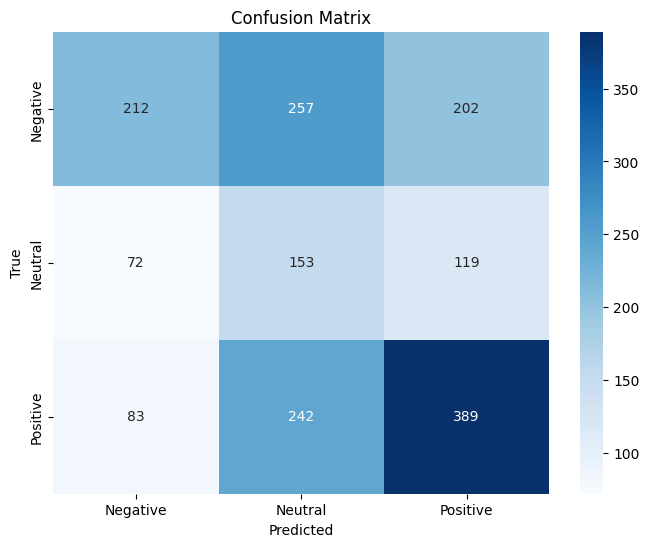

In [ ]:
y_true = rt_test['Sentiment'].to_list()
make_confusion_matrics(y_true, predicted_sentiments)

# 4 Treino de um modelo (aprendizagem automática)
Deverá agora tentar treinar um modelo, com o objetivo de tentar melhorar ainda mais os resultados de classificação obtidos:

1. Treine um modelo com os dados de treino, usando uma ferramenta de classificação à sua escolha, tal como por exemplo scikit-learn, etc.
2. Aplique o modelo que construiu ao conjunto de teste, avalie os resultados obtidos e compare-os com os resultados obtidos na tarefa anterior.

Faça várias experiências usando diferentes conjuntos ou tipos de features e documente os resultados obtidos. Exemplos de experiências: variar o número de features; usar maiúsculas e minúsculas
ou apenas minúsculas; diferentes tipos de pré-processamento (e.g. normalização de palavras, stemming); com e sem part-of-speech ; usando entidades mencionadas; usando GloVe (embeddings); etc.

Observação. Pode basear o seu trabalho em receitas disponíveis na Internet, no entanto deve fazer
referência a todo o tipo de material que utilizar, incluindo o endereço onde se encontra a respetiva
informação

Prepare data

### LSTM Based Model

Defenindo e preparendo as dados de traino e de teste.

In [ ]:
lstm_checkpoint_path = "./checkpoints/glove_lstm_model_checkpoint.h5"

X = rt_train["Text"].tolist()
y = rt_train["Sentiment"].tolist()

X_test = rt_test["Text"].tolist()
y_test = rt_test["Sentiment"].tolist()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_test = label_encoder.transform(y_test)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X_test = tokenizer.texts_to_sequences(X_test)
max_len = max(len(x) for x in X)
X = pad_sequences(X, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

Carregando os GloVe embeddings e cosntruindo a matrix de embeddings

In [ ]:

embeddings_index = {}
with open('./glove.6B/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Defenindo e compilando o modelo, juntamento com o carregamento do mesmo se este estiver previamente guardado

In [ ]:
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len),
    LSTM(128, dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

try:
    model.load_weights(lstm_checkpoint_path)
except:
    pass

Treinando o modelo

In [ ]:
checkpoint = ModelCheckpoint(lstm_checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(X, y, validation_split=0.2, epochs=10, batch_size=32, callbacks=[checkpoint])

Avaliando os dados de teste e calculando o valor das metricas de avaliação

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = np.mean(y_pred == y_test)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Plot da matrix de confusão

In [ ]:
make_confusion_matrics(y_test, y_pred)

### LSTM Bidirectional Based Model

Defenindo e preparando as dados de traino e de teste.

In [ ]:
bidirectional_lstm_model_checkpoint = "./checkpoints/bidirectional_lstm_model_checkpoint.h5"

X = rt_train["Text"].tolist()
y = rt_train["Sentiment"].tolist()

X_test = rt_test["Text"].tolist()
y_test = rt_test["Sentiment"].tolist()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_test = label_encoder.transform(y_test)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X_test = tokenizer.texts_to_sequences(X_test)
max_len = max(len(x) for x in X)
X = pad_sequences(X, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

Carregando os GloVe embeddings e cosntruindo a matrix de embeddings

In [ ]:
embeddings_index = {}
with open('./glove.6B/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Defenindo e compilando o modelo, juntamento com o carregamento do mesmo se este estiver previamente guardado

In [ ]:
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len),
    Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

try:
    model.load_weights(bidirectional_lstm_model_checkpoint)
except:
    pass

Trainar o modelo

In [ ]:
checkpoint = ModelCheckpoint(bidirectional_lstm_model_checkpoint, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit(X, y, validation_split=0.2, epochs=1, batch_size=32, callbacks=callbacks_list)

Avaliando os dados de teste e calculando o valor das metricas de avaliação

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = np.mean(y_pred == y_test)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Construindo a matris de confusão

In [ ]:
make_confusion_matrics(y_test, y_pred)

# 5 Utilização de transformadores para classificação
Deverá agora aplicar um modelo pré-treinado, baseado em transformadores, aos seus dados: 

a) Numa primeira etapa poderá fazer experiências simples, recorrendo a pipelines já definidos, aplicando um ou mais modelos existentes; 

b) Numa segunda etapa, use os seus dados para fazer fine tuning ao modelo pré-treinado e assim conseguir ainda melhores resultados.

### DistilBert Base Uncased pre-trained

Defenindo e preparando as dados de traino e de teste.

In [ ]:
distilbert_model_checkpoint = "checkpoints/distilbert_model_checkpoint.h5"

X = rt_train["Text"].tolist()
y = rt_train["Sentiment"].tolist()

X_test = rt_test["Text"].tolist()
y_test = rt_test["Sentiment"].tolist()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_test = label_encoder.transform(y_test)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

X_train_encoded = tokenizer(X, padding=True, truncation=True, return_tensors='tf')
X_test_encoded = tokenizer(X_test, padding=True, truncation=True, return_tensors='tf')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Defenindo e compilando o modelo, juntamento com o carregamento do mesmo se este estiver previamente guardado

In [ ]:
input_ids = tf.keras.Input(shape=(None,), name='input_ids', dtype='int32')
attention_mask = tf.keras.Input(shape=(None,), name='attention_mask', dtype='int32')
outputs = model({'input_ids': input_ids, 'attention_mask': attention_mask})[0]
pooled_output = GlobalAveragePooling1D()(outputs)
dropout = Dropout(0.2)(pooled_output)
output = Dense(3, activation='softmax')(dropout)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(distilbert_model_checkpoint, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

try:
    model.load_weights(bidirectional_lstm_model_checkpoint)
except:
    pass

Treinar o modelo

In [ ]:
history = model.fit({'input_ids': X_train_encoded['input_ids'], 'attention_mask': X_train_encoded['attention_mask']}, y,
                    validation_split=0.2, epochs=70, batch_size=32, callbacks=[checkpoint])

Avaliando os dados de teste e calculando o valor das metricas de avaliação

In [ ]:
y_pred = model.predict({'input_ids': X_test_encoded['input_ids'], 'attention_mask': X_test_encoded['attention_mask']})
y_pred_labels = np.argmax(y_pred, axis=1)

y_pred_labels = label_encoder.inverse_transform(y_pred_labels)
y_test_labels = label_encoder.inverse_transform(y_test)

report = classification_report(y_test_labels, y_pred_labels, labels=np.unique(y_test_labels), output_dict=True)

print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

accuracy = report['accuracy']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Construindo a matrix de confusão

In [ ]:
make_confusion_matrics(y_test_labels, y_pred_labels)

## 6 Usar modelos generativos para classificação de sentimento
Finalmente, deverá aplicar um modelo generativo, tal como o chatGPT ou Google Gemini ou outro,
para atribuir as etiquetas “pos”, “neg” ao conjunto de dados notebook-challenge.txt, que é fornecido
sem etiquetas e que contém 421 reviews escritas em português sobre computadores portáteis. Este
conjunto encontra-se no moodle (também se encontra dentro da diretoria data/pt-sentiment ao descomprimir o ficheiro tm-data.zip). Deverá usar o sistema que lhe parecer ter melhor desempenho
para atribuir automaticamente as etiquetas a estes dados. Juntamente com esse ficheiro, encontrase o ficheiro notebook-train.csv, que contém cerca de 1500 reviews previamente classificadas e que
pode ser utilizado para fazer as suas experiências e que lhe permite verificar se está a obter bons
resultados. Juntamente com o seu relatório, deverá submeter o ficheiro notebook-challenge.csv, que
deve seguir o formato do ficheiro notebook-train.csv, com as colunas “sentiment” e “review_text”,
em que a coluna “sentiment” é calculada automaticamente pelo seu sistema. Exemplo:\
sentiment review_text\
pos O note é bom, mas não superou as expectativas . . .\
pos Ele corresponde ao valor pago . Custando em . . .\
pos O notebook é muito bom, o Windows 10 ferra um pouco com a velocidade , mas isso . . .\
pos O notebook tem uma tela enorme , muito útil para . . .\
neg Comprei para estudar , ainda não instalei um único programa . . .

#### Preparing datasets

In [31]:
notebooks_train = pd.read_csv('./notebooks-train.csv', sep='\t')

with open('./notebooks-challenge.txt', 'r', encoding='utf-8') as file:
    notebooks_test = [line.strip() for line in file.readlines()]

#notebooks_test[0]
notebooks_train

,sentiment,review_text
0,pos,Estou contente com a compra entrega rápida o ú...
1,pos,"Excelente!!! Produto muito bom, bonito, design..."
2,pos,"Superou expectativas É excelente para jogos, ..."
3,pos,Comprei o mesmo para minha irmã e ela me conto...
4,pos,Notebbok muito bom! Rápido pequeno e leve para...
...,...,...
1495,neg,Fiz a compra dia 12/04/2018 era pra ter chegad...
1496,pos,excelente produto foi além da minha expectativ...
1497,pos,Produto atendeu as expectativas estava conform...
1498,pos,Ótimo produto vei tudo certo e rapido notbook ...


### Sentiment SiEBERT pre-trained
#### Model Sourced from Hugging Face: siebert/sentiment-roberta-large-english

#### Run Sentiment Analysis on test sample

In [ ]:
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

output = pd.DataFrame(columns=['sentiment', 'review_text'])

for review in notebooks_test:
    sent = sentiment_analysis(review)

    result = {
        'sentiment': 'pos' if sent[0]['label'] == 'POSITIVE' else 'neg',
        'review_text': review
    }

    output = pd.concat([output, pd.DataFrame(result, index=[0])], ignore_index=True)

In [ ]:
output.to_csv('./notebooks-challenge.csv', sep='\t')

### Test with training dataset

In [36]:
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

output = pd.DataFrame(columns=['real_sentiment', 'sentiment', 'review_text'])

for row in notebooks_train.iterrows():
    sent = sentiment_analysis(row[1].at['review_text'])

    result = {
        'real_sentiment': row[1].at['sentiment'],
        'sentiment': 'pos' if sent[0]['label'] == 'POSITIVE' else 'neg',
        'review_text': row[1].at['review_text']
    }

    output = pd.concat([output, pd.DataFrame(result, index=[0])], ignore_index=True)

output

,real_sentiment,sentiment,review_text
0,pos,pos,Estou contente com a compra entrega rápida o ú...
1,pos,pos,"Excelente!!! Produto muito bom, bonito, design..."
2,pos,pos,"Superou expectativas É excelente para jogos, ..."
3,pos,pos,Comprei o mesmo para minha irmã e ela me conto...
4,pos,pos,Notebbok muito bom! Rápido pequeno e leve para...
...,...,...,...
1495,neg,pos,Fiz a compra dia 12/04/2018 era pra ter chegad...
1496,pos,pos,excelente produto foi além da minha expectativ...
1497,pos,pos,Produto atendeu as expectativas estava conform...
1498,pos,pos,Ótimo produto vei tudo certo e rapido notbook ...


In [37]:
accuracy, precision, recall, f1, classification, conf_matrix = get_stats(desired=output['real_sentiment'].to_list(), estimated=output['sentiment'].to_list())

Accuracy: 0.8933333333333333
Precision: 0.8887566271002162
Recall: 0.8933333333333333
F1 Score: 0.8858629001474753
Classification Report: 
              precision    recall  f1-score   support

         neg       0.83      0.58      0.68       295
         pos       0.90      0.97      0.94      1205

    accuracy                           0.89      1500
   macro avg       0.87      0.77      0.81      1500
weighted avg       0.89      0.89      0.89      1500

Confusion Matrix: 
[[ 171  124]
 [  36 1169]]


### Ollama with LLaMa2

In [20]:
import ollama
#ollama.pull('llama2')

### Test with test dataset

In [50]:
sentiment_output = []

for row in notebooks_test:
    response = ollama.generate(model='llama2', prompt=f'Retorna-me a resposta com um "neg" para negativo e um "pos" para positivo. APENAS DEVE VIR "neg" OU "pos" NO OUTPUT SEM QUALQUER OUTRO TIPO DE TEXTO NO OUTPUT. Por favor dá-me uma analise de sentimento da seguinte frase: {row}', options={'temperature': 0})
    sentiment_output.append(response['response'])

In [75]:
llama2_test_output = pd.DataFrame(columns=['sentiment', 'review_text'])

for index, row in enumerate(sentiment_output):
    clean_row = row.replace("\n", "")

    if clean_row == 'Pos' or clean_row == 'Neg':

        if clean_row == 'Pos':
            llama_sentiment = 'pos'
        elif clean_row == 'Neg':
            llama_sentiment = 'neg'

        result = {
        'sentiment':  llama_sentiment,
        'review_text': notebooks_test[index]
        }

    llama2_test_output = pd.concat([llama2_test_output, pd.DataFrame(result, index=[0])], ignore_index=True)

llama2_test_output
    

,sentiment,review_text
0,pos,"O note é bom, mas não superou as expectativas ..."
1,pos,Ele corresponde ao valor pago. Custando em méd...
2,pos,"O notebook é muito bom, o Windows 10 ferra um ..."
3,pos,"O notebook tem uma tela enorme, muito útil par..."
4,pos,"O notebook tem uma tela enorme, muito útil par..."
...,...,...
417,pos,"Produto ótimo, entrega rápida gostei da atençã..."
418,pos,O anúncio está péssimo. Não tem informação nen...
419,pos,"Gostei muito, além de lindo, é muito eficiente..."
420,pos,"Gostei muito, além de lindo, é muito eficiente..."


In [76]:
llama2_test_output.to_csv('./notebooks-challenge-llama2.csv', sep='\t')

### Test with training dataset

In [81]:
llama2_train_output = pd.DataFrame(columns=['real_sentiment', 'sentiment', 'review_text'])

def concat_result(llama_df, llama_sentiment, row):
    result = {
            'real_sentiment': row.at['sentiment'],
            'sentiment': llama_sentiment,
            'review_text': row.at['review_text']
        }

    return pd.concat([llama_df, pd.DataFrame(result, index=[0])], ignore_index=True)

for index, row in notebooks_train.iterrows():
    response = ollama.generate(model='llama2', prompt=f'Retorna-me a resposta com um "neg" para negativo e um "pos" para positivo. APENAS DEVE VIR "neg" OU "pos" NO OUTPUT SEM QUALQUER OUTRO TIPO DE TEXTO NO OUTPUT. Por favor dá-me uma analise de sentimento da seguinte frase: {row.at["review_text"]}', options={'temperature': 0})
    response = response['response']
    clean_row = response.replace("\n", "")

    if clean_row == 'Pos' or clean_row == 'Neg':

        if clean_row == 'Pos':
            llama_sentiment = 'pos'
            llama2_train_output = concat_result(llama2_train_output, llama_sentiment, row)
        elif clean_row == 'Neg':
            llama_sentiment = 'neg'
            llama2_train_output = concat_result(llama2_train_output, llama_sentiment, row)

    if index == 200:
        break
        

llama2_train_output

,real_sentiment,sentiment,review_text
0,pos,pos,Estou contente com a compra entrega rápida o ú...
1,pos,pos,"Excelente!!! Produto muito bom, bonito, design..."
2,pos,pos,"Superou expectativas É excelente para jogos, ..."
3,pos,pos,Comprei o mesmo para minha irmã e ela me conto...
4,pos,pos,Notebbok muito bom! Rápido pequeno e leve para...
...,...,...,...
190,pos,pos,Recomendou-lhe apresentação conforme descrito ...
191,pos,pos,"comprei já tem 1 semana, funcionando perfeitam..."
192,pos,pos,"Gostei muito desse note pequeno, leve bonito e..."
193,neg,pos,"Não recomendo, Noteboock lento, periodicamente..."


In [82]:
accuracy, precision, recall, f1, classification, conf_matrix = get_stats(desired=llama2_train_output['real_sentiment'].to_list(), estimated=llama2_train_output['sentiment'].to_list())

Accuracy: 0.882051282051282
Precision: 0.8961805555555556
Recall: 0.882051282051282
F1 Score: 0.8390358837201897
Classification Report: 
              precision    recall  f1-score   support

         neg       1.00      0.12      0.21        26
         pos       0.88      1.00      0.94       169

    accuracy                           0.88       195
   macro avg       0.94      0.56      0.57       195
weighted avg       0.90      0.88      0.84       195

Confusion Matrix: 
[[  3  23]
 [  0 169]]
